# Atmospheric Data - preparation 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
hives_ids = [1300001, 1300002, 1400001, 1400002]
DATA_INIT = True

In [3]:
if DATA_INIT:
    dfh_hives = [pd.read_csv(f"measurements/{hive_id}/humidity.csv") for hive_id in hives_ids]
    dft_hives = [pd.read_csv(f"measurements/{hive_id}/temperature.csv") for hive_id in hives_ids]
    dfh_hivesWithoutDuplicates = [dfh_hive.drop_duplicates(subset=['timestamp'], keep=False) for dfh_hive in dfh_hives]
    dft_hivesWithoutDuplicates = [dft_hive.drop_duplicates(subset=['timestamp'], keep=False) for dft_hive in dft_hives]

    for idx, hive_id in enumerate(hives_ids):
        print(f"Hive no. {hives_ids[idx]} | humidity temperature dataset size : {dfh_hivesWithoutDuplicates[idx].shape} {dft_hivesWithoutDuplicates[idx].shape}")

    df_hive = [pd.merge(
        dfh_hivesWithoutDuplicates[idx], dft_hivesWithoutDuplicates[idx], on='timestamp', suffixes=(f"_humidity_{hive_id}",f"_temperature_{hive_id}"))
               for idx, hive_id in enumerate(hives_ids)]

    
    total = 0
    for atmosphere_data in df_hive:
        atmosphere_data['timestamp'] = pd.to_datetime(atmosphere_data['timestamp'], format='%Y-%m-%dT%H-%M-%S').sort_values()
        atmosphere_data.set_index('timestamp', inplace=True)
        print(f"Atmospheric data after merge: {atmosphere_data.shape}")
        total += atmosphere_data.shape[0]
    
    print(f"Total atmoshpere dataset size: {total}")

Hive no. 1300001 | humidity temperature dataset size : (6776, 2) (6786, 2)
Hive no. 1300002 | humidity temperature dataset size : (6865, 2) (6867, 2)
Hive no. 1400001 | humidity temperature dataset size : (2444, 2) (2457, 2)
Hive no. 1400002 | humidity temperature dataset size : (1948, 2) (1949, 2)
Atmospheric data after merge: (6696, 2)
Atmospheric data after merge: (6778, 2)
Atmospheric data after merge: (2418, 2)
Atmospheric data after merge: (1936, 2)
Total atmoshpere dataset size: 17828


# Sound Data - preparation

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
from functools import reduce

In [5]:
scaler = preprocessing.MinMaxScaler()

if DATA_INIT:
    hive_sounds = []
    for idx, hive_id in enumerate(hives_ids):
        print(f"Data preparation for hive: {hive_id}")

        sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        sound_hive_list = []
        for file in tqdm(sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                #np_samples = scaler.fit_transform(np_samples.reshape(-1, 1))
                hive_sounds.append([pd_timestamp, np_samples, np.eye(len(hives_ids))[idx]])
    
    # Normalize in place
    max_value = reduce(max, map(lambda x:max(x[1]), hive_sounds))
    for sound in hive_sounds:
        sound[1] = np.true_divide(sound[1], max_value)
        
    print(f"Size of hive sound data: {len(hive_sounds)}, with max value: {max_value}")
    np.random.shuffle(hive_sounds)
    np.save("sound_data_training.npy", hive_sounds)
    data = hive_sounds
else:
    data = np.load("sound_data_training.npy", allow_pickle=True)
    print(f"Loaded: {len(hive_sounds)} sound recordings.")

Data preparation for hive: 1300001


100%|██████████| 1664/1664 [00:30<00:00, 55.13it/s]


Data preparation for hive: 1300002


100%|██████████| 1637/1637 [00:40<00:00, 40.39it/s]


Data preparation for hive: 1400001


100%|██████████| 705/705 [00:14<00:00, 49.03it/s]


Data preparation for hive: 1400002


100%|██████████| 587/587 [00:11<00:00, 51.48it/s]


Size of hive sound data: 4529, with max value: 4080.0


# Basic classification

In [6]:
import librosa
import librosa.display

In [48]:
data[0][1]

array([0.5875    , 0.5852941 , 0.59068626, ..., 0.59117645, 0.59117645,
       0.5921569 ], dtype=float32)

In [88]:
mfccs_avg = []
for labeled_wave in tqdm(data):
    full_mfccs = librosa.feature.mfcc(y=labeled_wave[1], sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
    mfccs_avg.append([np.mean(full_mfccs,axis=1), np.argmax(labeled_wave[2])])

100%|██████████| 4529/4529 [00:20<00:00, 220.05it/s]


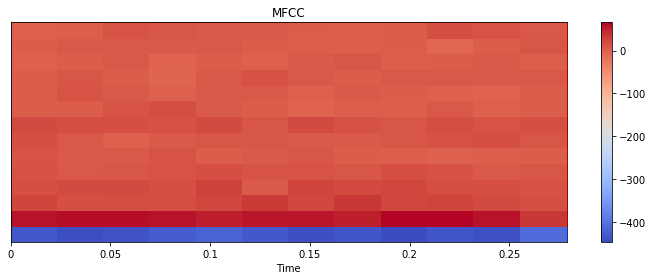

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print(mfccs_avg[0])
mfccs_avg_scaled = StandardScaler().fit_transform(mfccs_avg)

[array([-433.916    ,   56.89947  ,   24.371086 ,   19.562193 ,
         12.379212 ,    6.4121194,   10.363124 ,   16.178104 ,
          5.8511925,    4.526011 ,    6.8904724,    4.168711 ,
          4.904103 ,    7.6024795], dtype=float32), 3]


ValueError: setting an array element with a sequence.

In [73]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(mfccs_avg_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 4529, 'y' with size 4529.

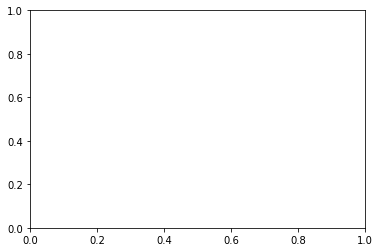

In [78]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'yellow']

principalDf.plot(kind='scatter',x='PC1',y='PC2',color=colors[])
plt.show()

# AUTOENCODER - BASIC

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
learning_rate = 1e-4

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3000, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256))
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import torch.utils.data as utils

sound_dataset = utils.TensorDataset(torch.Tensor([x[0] for x in training_data_sound]),
                                   torch.Tensor([x[1] for x in training_data_sound])) # create your datset
                                    
print("Length of complete sound dataset is", len(sound_dataset))
sound_trainset = torch.utils.data.DataLoader(sound_dataset, batch_size=20, shuffle=True)

In [ ]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

for epoch in range(num_epochs):
    for data in tqdm(sound_trainset):
        X, y = data
        model.zero_grad()
        output = model(X)
        loss = criterion(output, X)
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f"epoch [{epoch}/{num_epochs}], loss:{loss.item()}")

In [ ]:
torch.save(model.state_dict(), 'autoencoder-basic-model.pth')

### Evaluation

In [ ]:
model.load_state_dict(torch.load('autoencoder-basic-model.pth'))

In [ ]:
with torch.no_grad():
    for data in tqdm(sound_trainset):
        X, y = data
        output = model(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

# AUTOENCODER CNN

In [ ]:
a = [1,2,3,4,5,6,7,7,8,98,90,0]
print(a[-3:])

# PyTorch

# ---------------


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [ ]:
print(train)

In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=20, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=20, shuffle=True)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def weight_reset(m):
        if isinstance(m, nn.Linear):
            m.reset_parameters()
        
        
net = Net()


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-3)
EPOCHS = 6

net.weight_reset()

for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data
        net.zero_grad()
        output = net(X.view(-1, 784))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    print("Current loss is: ", loss.item())
    if loss < 1e-5:
        print("Loss threshold obtained!")
        break
        

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
print("Accuracy on test data: ", round(correct/total, 3))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
print("Accuracy on train data: ", round(correct/total, 3))